In [6]:
from generate_data import *
import numpy as np
from scipy.optimize import minimize
from numpy.linalg import norm
import warnings
warnings.filterwarnings("ignore")

global k, vk

In [7]:
Ts = 0.1

N = 10
Nu = 6
Lambda = 5e-8

# 1 - population, 2 - tracking, 3 - hiv
process = 3

In [8]:
if process == 1:
    x0 = [50, 20]
    y_zad = get_reference_population(x0)
    fun = population
    kmax, vk = len(y_zad), 0
    u = 5 * np.ones(kmax+Nu+N)
    bds = [(-100, 100)]
    model = get_population_model(Ts, thr=1e-4, deg=2)
elif process == 2:
    x0 = [0, 0, 0]
    y_zad = get_reference_tracking(x0)
    fun = tracking
    kmax, vk = len(y_zad), 0
    u = np.zeros(kmax+Nu+N)
    bds = [(-0.01, 0.01)]
    model = get_tracking_model(Ts, thr=1e-5, deg=3)
else:
    x05_stable = 0.05
    x0 = [11/20, 10/3, x05_stable, 0.0835-x05_stable, x05_stable]
    y_zad = get_reference_hiv(x0)
    fun = hiv
    kmax, vk = len(y_zad), 0
    u = 533/1078 * np.ones(kmax+Nu+N)
    bds = [(-1, 1)]
    model = get_hiv_model(Ts, thr=1e-4, deg=3)

x = np.zeros((kmax+N, len(x0)))
x[0:5, :] = x0

# 1. Stable initial condition: x1 = 5*x2-10*u, np. x, u = [(50, 20), 5]

(x1)[k+1] = 0.1000 1 + 0.9900 x1[k] + -0.1000 x1[k] x2[k] + 0.0980 x1[k] x2[k] u[k]
(x2)[k+1] = 0.9800 x2[k] + 0.1000 x1[k] x2[k] + -0.1000 x2[k] x4[k] + -0.1000 x2[k] x5[k] + -0.0980 x1[k] x2[k] u[k]
(x3)[k+1] = 0.9990 x3[k] + -0.0030 x2[k] x3[k] + 0.0060 x1[k] x2[k] x3[k]
(x4)[k+1] = 0.9900 x4[k] + 0.0030 x2[k] x4[k]
(x5)[k+1] = 0.9900 x5[k] + 0.0030 x2[k] x3[k]


In [9]:
def cost_function(deltau, model=None, w=[1]*len(x0)):
    u[k:k+Nu] = (np.tril(np.ones((Nu, Nu)), 0) @ deltau.reshape(-1, 1) + u[k-1] * np.ones((Nu,1))).reshape(-1)
    u[k+Nu:k+N+1] = u[k+Nu-1]

    if model is not None:
        x[k] = model.simulate(x[k-1], t=2, u=np.array([u[k]]))[-1] + vk
        for p in range(1, N):
            x[k+p] = model.simulate(x[k+p-1], t=2, u=np.array([u[k+p-1]]))[-1] + vk
    else:
        x[k] = fun(t=0, state=x[k-1], T=Ts, u=u[k])
        for p in range(1, N):
            x[k+p] = fun(t=0, state=x[k+p-1], T=Ts, u=u[k+p-1])

    return norm((y_zad[k]*w).reshape(-1, 1)*np.ones((1, N)) - (x[k:k+N]*w).T, 2) + Lambda * norm(deltau, 2)

In [10]:
state = x0
w = [0, 1, 0, 0, 0]

for k in range(5, kmax):
    xmod =  model.simulate(state, t=2, u=np.array([u[k-1]]))[-1]
    state = fun(t=0, state=state, T=Ts, u=u[k-1])

    x[k, :] = state

    try:
        opt = minimize(
            cost_function,
            args=(None, w),
            x0=np.zeros(Nu),
            method='SLSQP',
            bounds=bds * Nu,
            options={'maxiter': 100, 'ftol': 1e-6}
        )
        du = opt.x[0]
    except np.linalg.LinAlgError as e:
        print(f"Optimization failed due to: {e}")
        du = 0
    
    u[k] = u[k-1] + du
    u[k] = np.clip(u[k], -100, 100)

    vk = state - xmod

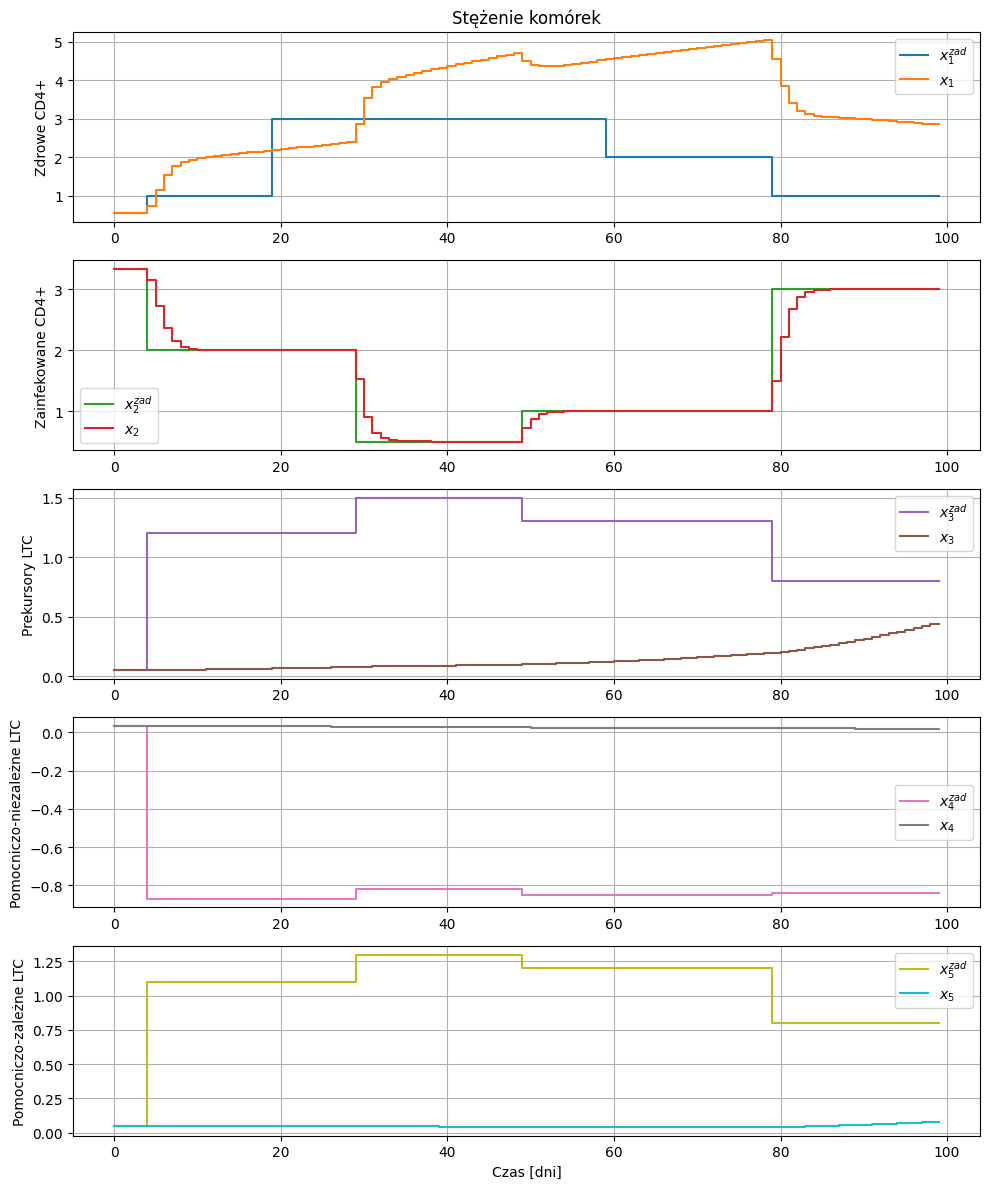

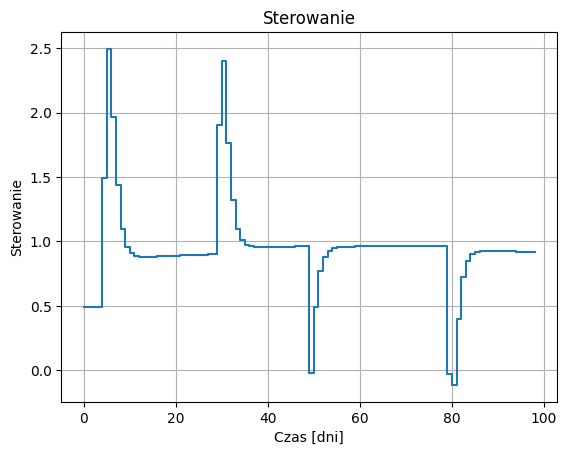

In [11]:
plot(y_zad, x, u, w, save=False)